In [22]:
import os

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models

import pickle
import json

In [2]:
train_dirs_paths = "dataset_updated/training_set"
test_dirs_paths = "dataset_updated/validation_set"

image_size = 150

input_shape = (image_size, image_size, 3)

classes = os.listdir(train_dirs_paths)

In [3]:
def read_image_as_numpy_array(image_path, target_size=(150, 150)):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image to RGB format (if not already in RGB)
    img = img.convert('RGB')
    # Resize the image to target size
    img = img.resize(target_size)
    # Convert the image to a NumPy array
    img_array = np.array(img)
    return img_array

In [4]:
def retrieve_images(dirs_path, target_size=(150, 150)):
    X = []
    y = []
    filename_paths = []
    problematic_files = []

    for class_ in classes:
        base_class_path = os.path.join(dirs_path, class_)
        
        for filename in os.listdir(base_class_path):
            try:
                image_path = os.path.join(base_class_path, filename)
                img_array = read_image_as_numpy_array(image_path, target_size=target_size)
                X.append(img_array)
                y.append(class_)
                filename_paths.append(image_path)
            
            except Exception as e:
                problematic_files.append(image_path)

    X = np.array(X)
    y = np.array(y)
    filename_paths = np.array(filename_paths)

    return X, y, filename_paths, problematic_files

In [25]:
X, y, filename_paths, _ = retrieve_images(train_dirs_paths, target_size=input_shape[:2])

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

/home/jucajagu/anaconda3/envs/gpu-terminator/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Shape of X: (8188, 150, 150, 3)
Shape of y: (8188,)


In [26]:
def drop_duplicate_images(X, y, filename_paths):
    # Reshape X to a 2D array where each row is a flattened version of the (150, 150, 3) array
    X_reshaped = X.reshape(X.shape[0], -1)

    # Use np.unique to find the unique rows
    _, indices = np.unique(X_reshaped, axis=0, return_index=True)

    # Retrieve the unique arrays in the original shape
    X_unique = X[indices]
    y_unique = y[indices]
    filename_paths_unique = np.array(filename_paths)[indices]

    print(f"Original shape: {X.shape}")
    print(f"Shape after removing duplicates: {X_unique.shape}")

    return X_unique, y_unique, filename_paths_unique

In [28]:
X, y, filename_paths = drop_duplicate_images(X, y, filename_paths)

# Encode class labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

with open("label_encoder.pickle", "wb") as file:
    pickle.dump(label_encoder, file)

np.save('X.npy', X)
np.save('y.npy', y)
np.save('y_encoded.npy', y_encoded)
np.save('file_paths.npy', filename_paths)

Original shape: (8188, 150, 150, 3)
Shape after removing duplicates: (6621, 150, 150, 3)


In [2]:
X = np.load("X.npy")
y = np.load("y.npy")
y_encoded = np.load("y_encoded.npy")

filename_paths = np.load("file_paths.npy")

with open('label_encoder.pickle', 'rb') as f:
    label_encoder = pickle.load(f)

In [10]:
def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', name='conv2d_3')(inputs)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_3')(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_4')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_4')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_5')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_5')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_6')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_6')(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', name='conv2d_7')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_7')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d_1')(x)

    x = layers.Dense(128, activation="relu", name='dense_8')(x)

    x = layers.Dense(128, activation="relu", name='dense_9')(x)

    x = layers.Dense(128, activation="relu", name='dense_10')(x)

    x = layers.Dense(128, activation="linear", name='dense_11')(x)

    outputs = layers.Dense(num_classes, activation='softmax', name='dense_12')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Parameters
num_classes = len(classes)
k = 5  # Number of folds
epochs = 25
batch_size = 32

# Initialize KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Arrays to store results
history_list = []

# Perform K-fold cross-validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]
    
    model = create_model(input_shape, num_classes)
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    history_list.append(history)

Epoch 1/25
166/166 [==============================] - 4s 14ms/step - loss: 1.2378 - accuracy: 0.5674 - val_loss: 1.0470 - val_accuracy: 0.5668
Epoch 2/25
 35/166 [=====>........................] - ETA: 1s - loss: 0.9294 - accuracy: 0.6313

166/166 [==============================] - 2s 13ms/step - loss: 0.8918 - accuracy: 0.6611 - val_loss: 0.8954 - val_accuracy: 0.6649
Epoch 3/25
166/166 [==============================] - 2s 13ms/step - loss: 0.8171 - accuracy: 0.7013 - val_loss: 0.7168 - val_accuracy: 0.7442
Epoch 4/25
166/166 [==============================] - 2s 13ms/step - loss: 0.7042 - accuracy: 0.7379 - val_loss: 0.6983 - val_accuracy: 0.7336
Epoch 5/25
166/166 [==============================] - 2s 13ms/step - loss: 0.6661 - accuracy: 0.7457 - val_loss: 0.6311 - val_accuracy: 0.7819
Epoch 6/25
166/166 [==============================] - 2s 14ms/step - loss: 0.6163 - accuracy: 0.7717 - val_loss: 0.7197 - val_accuracy: 0.7464
Epoch 7/25
166/166 [==============================] - 2s 13ms/step - loss: 0.5758 - accuracy: 0.7810 - val_loss: 0.6733 - val_accuracy: 0.7547
Epoch 8/25
166/166 [==============================] - 2s 13ms/step - loss: 0.5277 - accuracy: 0.7951 - val_loss: 0.6251 - val_accuracy: 0.7781
Epoch 9/25

## Gráficos de Precisión y Perdida

In [14]:
# Save training history using pickle
with open('training_history.pickle', 'wb') as file:
    pickle.dump(history_list, file)

In [7]:
with open('training_history.pickle', 'rb') as f:
    history_list = pickle.load(f)

2024-05-27 20:06:35.164287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 20:06:35.205931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 20:06:35.206030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 20:06:35.207681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 20:06:35.207749: I external/local_xla/xla/stream_executor

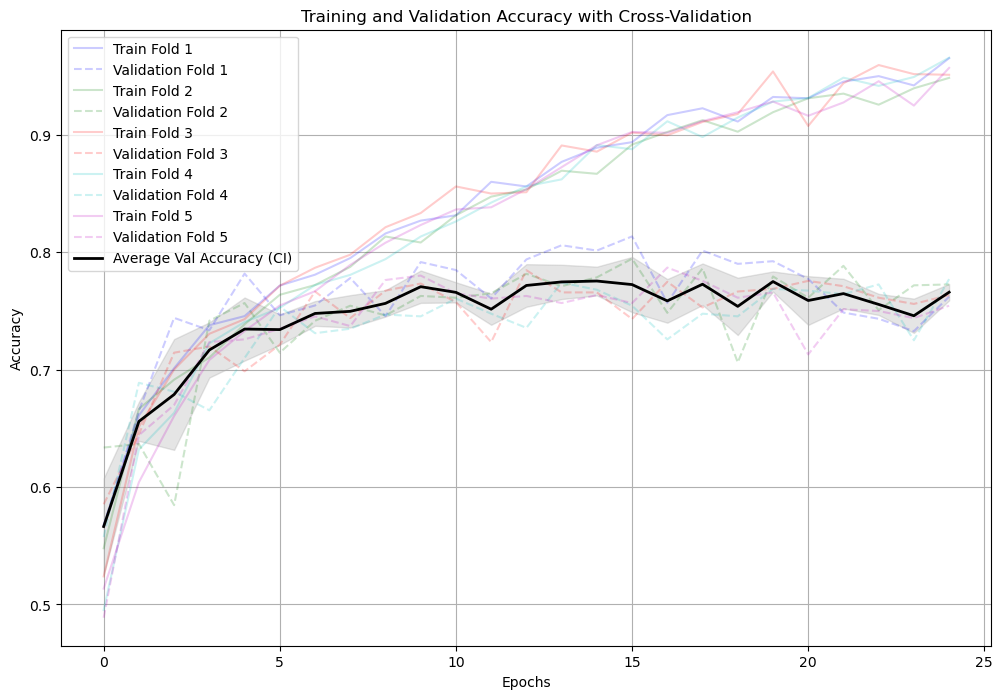

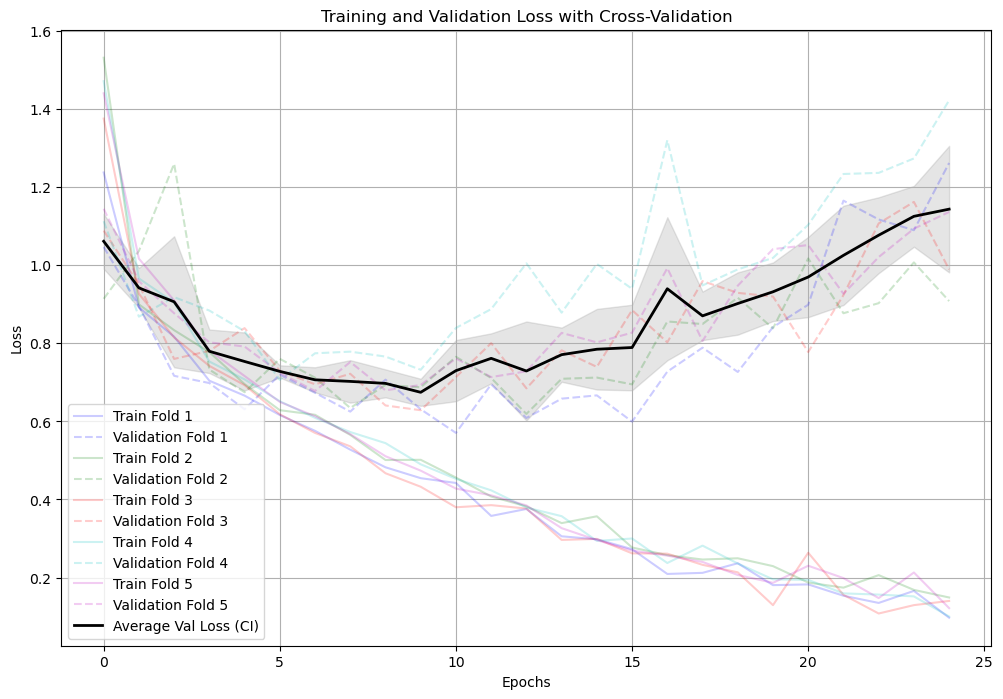

In [8]:
# Plot cross-validation results
def plot_cross_validation_results(history_list, metric='accuracy', ci=True, average_score=True):
    plt.figure(figsize=(12, 8))
    
    # Define a larger list of colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'olive']
    # You can add more colors or change the existing ones as needed
    
    # Arrays to store metrics for all folds
    all_metrics = []

    alpha = 0.2 if ci else 1
    
    # Plot training and validation metrics for each fold
    for i, history in enumerate(history_list):
        color = colors[i % len(colors)]  # Cycle through colors
        
        # Plot individual fold metrics
        plt.plot(history.history[metric], label=f'Train Fold {i+1}', color=color, alpha=alpha)
        plt.plot(history.history[f'val_{metric}'], label=f'Validation Fold {i+1}', linestyle="--", color=color, alpha=alpha)
        
        # Store validation metrics for computing average and CI
        all_metrics.append(history.history[f'val_{metric}'])
    
    # Calculate average and confidence interval
    all_metrics = np.array(all_metrics)
    mean_metric = np.mean(all_metrics, axis=0)
    std_metric = np.std(all_metrics, axis=0)
    ci_lower = mean_metric - 1.96 * (std_metric / np.sqrt(len(history_list)))  # 95% confidence interval
    ci_upper = mean_metric + 1.96 * (std_metric / np.sqrt(len(history_list)))  # 95% confidence interval
    
    # Plot average metric with CI lines
    if average_score:
        plt.plot(mean_metric, label=f'Average Val {metric.capitalize()} (CI)', color='k', linewidth=2)
        if ci:
            plt.fill_between(range(len(mean_metric)), ci_lower, ci_upper, color='gray', alpha=0.2)
    
    plt.title(f'Training and Validation {metric.capitalize()} with Cross-Validation')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()

plot_cross_validation_results(history_list, metric='accuracy', ci=True, average_score=True)
plot_cross_validation_results(history_list, metric='loss')

After 10 epocs the model has no improvement and starts to overfit, hence the model is trained with the data to that stage

In [16]:
model = create_model(input_shape, num_classes)
    
EPOCHS = 10
num_classes = len(classes)
batch_size = 32

history = model.fit(
    X, y_encoded,
    epochs=EPOCHS,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/10


2024-05-27 20:09:45.765064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-27 20:09:46.296125: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2a69647900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-27 20:09:46.296160: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-27 20:09:46.301912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716858586.376478    1435 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 91/207 [============>.................] - ETA: 1s - loss: 1.7518 - accuracy: 0.4557

207/207 [==============================] - 7s 16ms/step - loss: 1.3449 - accuracy: 0.5374
Epoch 2/10
207/207 [==============================] - 2s 12ms/step - loss: 0.9424 - accuracy: 0.6455
Epoch 3/10
207/207 [==============================] - 2s 11ms/step - loss: 0.8144 - accuracy: 0.6975
Epoch 4/10
207/207 [==============================] - 2s 11ms/step - loss: 0.7299 - accuracy: 0.7259
Epoch 5/10
207/207 [==============================] - 2s 11ms/step - loss: 0.6720 - accuracy: 0.7514
Epoch 6/10
207/207 [==============================] - 2s 11ms/step - loss: 0.6206 - accuracy: 0.7738
Epoch 7/10
207/207 [==============================] - 2s 11ms/step - loss: 0.5605 - accuracy: 0.7923
Epoch 8/10
207/207 [==============================] - 2s 11ms/step - loss: 0.5416 - accuracy: 0.7981
Epoch 9/10
207/207 [==============================] - 2s 11ms/step - loss: 0.4686 - accuracy: 0.8198
Epoch 10/10
207/207 [==============================] - 2s 11ms/step - loss: 0.4369 - accuracy: 0.8317


In [17]:
model.save("model.h5")

/home/jucajagu/anaconda3/envs/gpu-terminator/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
model = tf.keras.models.load_model('model.h5')

2024-05-27 22:40:42.803175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:40:43.013313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:40:43.013392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:40:43.014795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:40:43.014851: I external/local_xla/xla/stream_executor

## Análisis de Separabilidad Embeddings

In [26]:
def create_visual_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', name='conv2d_3')(inputs)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_3')(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_4')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_4')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_5')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_5')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_6')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_6')(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', name='conv2d_7')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_7')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d_1')(x)

    x = layers.Dense(128, activation="relu", name='dense_8')(x)

    x = layers.Dense(128, activation="relu", name='dense_9')(x)

    x = layers.Dense(128, activation="relu", name='dense_10')(x)

    x = layers.Dense(3, activation="linear", name='dense_11')(x)

    outputs = layers.Dense(num_classes, activation='softmax', name='dense_12')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [27]:
visual_model = create_visual_model(input_shape, num_classes)

visual_model.fit(
    X, y_encoded,
    epochs=EPOCHS,
    batch_size=batch_size,
)

Epoch 1/10
 65/207 [========>.....................] - ETA: 1s - loss: 1.6992 - accuracy: 0.4481

207/207 [==============================] - 4s 12ms/step - loss: 1.3278 - accuracy: 0.5280
Epoch 2/10
207/207 [==============================] - 2s 12ms/step - loss: 0.9804 - accuracy: 0.6371
Epoch 3/10
207/207 [==============================] - 2s 12ms/step - loss: 0.8404 - accuracy: 0.6973
Epoch 4/10
207/207 [==============================] - 2s 11ms/step - loss: 0.7707 - accuracy: 0.7087
Epoch 5/10
207/207 [==============================] - 2s 11ms/step - loss: 0.6652 - accuracy: 0.7577
Epoch 6/10
207/207 [==============================] - 2s 11ms/step - loss: 0.6260 - accuracy: 0.7629
Epoch 7/10
207/207 [==============================] - 2s 11ms/step - loss: 0.5813 - accuracy: 0.7821
Epoch 8/10
207/207 [==============================] - 2s 11ms/step - loss: 0.5250 - accuracy: 0.8014
Epoch 9/10
207/207 [==============================] - 2s 11ms/step - loss: 0.4930 - accuracy: 0.8163
Epoch 10/10
207/207 [==============================] - 2s 11ms/step - loss: 0.4436 - accuracy: 0.8352


In [28]:
sub_network = models.Model(inputs=visual_model.input, outputs=visual_model.layers[-2].output)
sub_network.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

In [29]:
vector_prediction = sub_network.predict(X)
vector_prediction

207/207 [==============================] - 1s 2ms/step


array([[  3.0240884 ,  -5.2948704 ,   3.4965293 ],
       [  9.371653  ,  14.928451  , -10.781056  ],
       [ 16.153755  ,  24.59773   , -13.737508  ],
       ...,
       [ -2.9933553 ,   0.51836973,   3.6758351 ],
       [ -3.4125412 ,   1.004163  ,   4.1491575 ],
       [  2.6613035 ,   1.2789255 ,  -1.6163728 ]], dtype=float32)

In [30]:
x_vector, y_vector, z_vector = vector_prediction[:,0], vector_prediction[:,1], vector_prediction[:,2]

fig = px.scatter_3d(x=x_vector, y=y_vector, z=z_vector, color=y, opacity=0.6)
fig.update_traces(marker_size=5)

## Test Unitarios

2024-05-27 22:41:01.782781: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


1/1 [==============================] - 2s 2s/step
Predicted Class Label: sculpture
Probability Prediction: 0.65


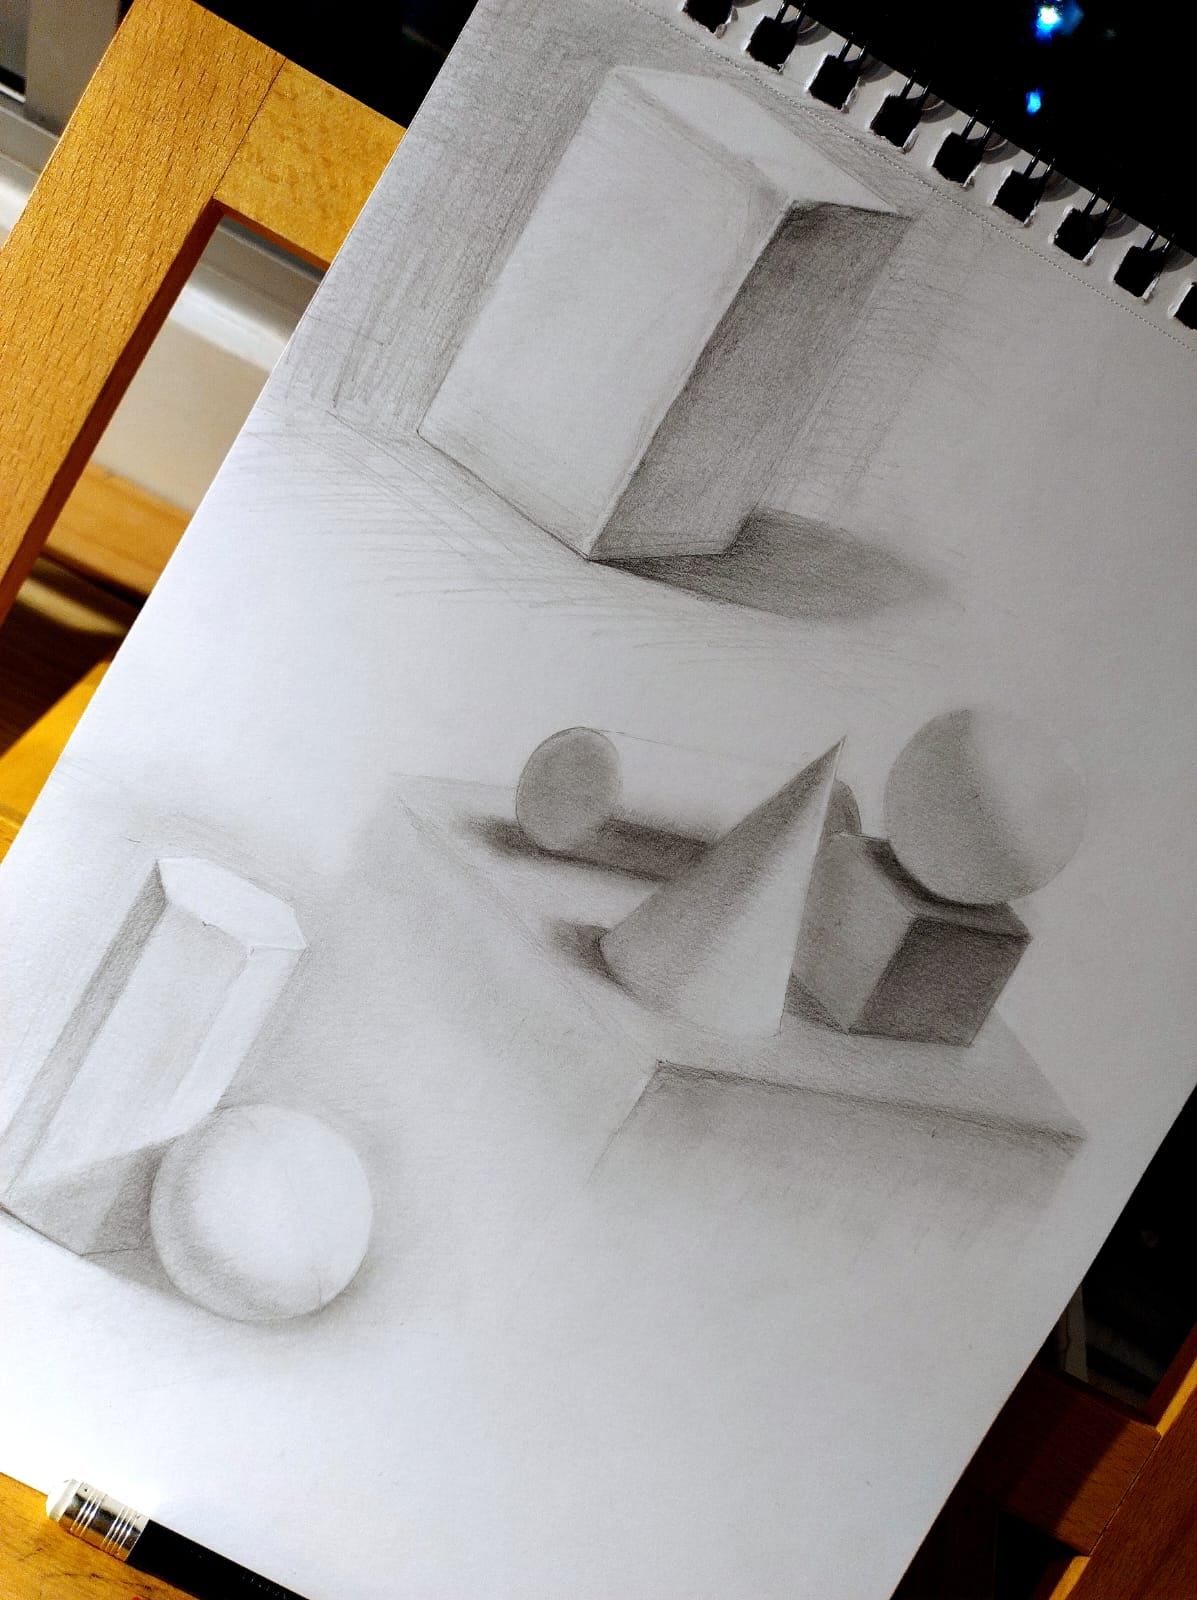

In [7]:
test_image_path = "unitary_tests/test.jpg"
test_image = read_image_as_numpy_array(test_image_path, target_size=input_shape[:2])
test_image = np.expand_dims(test_image, axis=0) 

test_instance_prediction = model.predict(test_image)

predicted_label_encoded = np.argmax(test_instance_prediction, axis=1)[0]  # Get the index of the highest probability

predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]  # Inverse transform to get the class label

print("Predicted Class Label:", predicted_label)
print("Probability Prediction:", np.round(np.max(test_instance_prediction), 2))

im = Image.open(test_image_path)
im.show()

In [8]:
neighbors_sub_network = models.Model(inputs=model.input, outputs=model.layers[-2].output)
neighbors_sub_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496 

In [14]:
neighbors_sub_network.save("neighbor_model.h5")

/home/jucajagu/anaconda3/envs/gpu-terminator/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
neighbors_sub_network = tf.keras.models.load_model('neighbor_model.h5')

2024-05-27 22:50:49.919124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:50:49.929372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:50:49.929434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:50:49.931144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-27 22:50:49.931200: I external/local_xla/xla/stream_executor

In [4]:
neighbors_matrix = neighbors_sub_network.predict(X)

2024-05-27 22:50:53.998788: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


207/207 [==============================] - 1s 3ms/step


In [28]:
# Reshape y to be (6621, 1) and ensure it is treated as strings
y = y.astype(str).reshape(-1, 1)

# Ensure filename_paths is a column vector with shape (6621, 1)
filename_paths = filename_paths.reshape(-1, 1)

# Concatenate the arrays along the second axis
embedding_images = np.concatenate([neighbors_matrix, y, filename_paths], axis=1)

# Convert the concatenated array to a DataFrame
embedding_images_df = pd.DataFrame(embedding_images)

embedding_images_df.to_csv("embedding_images.csv")

In [ ]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5).fit(neighbors_matrix)

In [27]:
test_vector = neighbors_sub_network.predict(test_image)
test_vector

1/1 [==============================] - 0s 12ms/step


array([[ 1.01100576e+00,  6.32300228e-02, -1.72433913e-01,
         6.56110168e-01,  2.64451265e-01, -4.46178466e-02,
         3.37966979e-01, -4.62383360e-01,  6.75982684e-02,
        -1.75373435e-01,  2.93412656e-01, -8.69130045e-02,
         4.61833358e-01, -5.75350486e-02,  5.05636297e-02,
         9.31132212e-02, -6.80149734e-01,  4.98471320e-01,
         1.76953018e-01,  1.94685906e-02, -1.99182570e-01,
         1.96229532e-01, -1.49450377e-02,  4.28831041e-01,
        -8.37668553e-02, -6.77109808e-02,  7.84581900e-03,
         1.24677427e-01, -3.27030897e-01, -3.62867981e-01,
        -6.08301222e-01,  3.10809195e-01,  4.49714005e-01,
         6.19730055e-01, -4.15980160e-01,  8.71577024e-01,
         8.27258974e-02, -3.77254516e-01, -5.77993155e-01,
        -8.01610872e-02,  4.74643290e-01, -3.16014588e-01,
         1.94197640e-01, -6.13941371e-01, -2.37397030e-01,
         5.18452585e-01, -5.92891693e-01,  5.21804452e-01,
         1.45828754e-01, -2.46914417e-01, -2.04834595e-0

In [29]:
_, indices = nbrs.kneighbors(test_vector)

dataset_updated/training_set/sculpture/i - 1253.jpeg


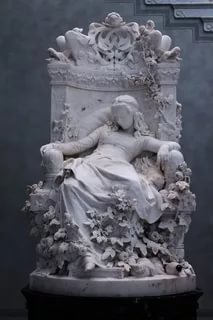

dataset_updated/training_set/sculpture/i - 1312.jpeg


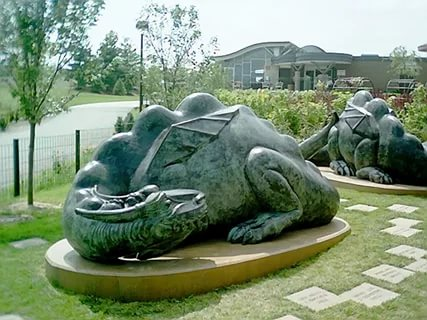

dataset_updated/training_set/sculpture/i - 1292.jpeg


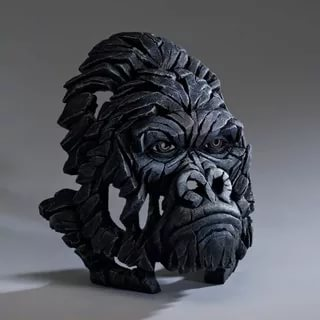

dataset_updated/training_set/sculpture/i - 777.jpeg


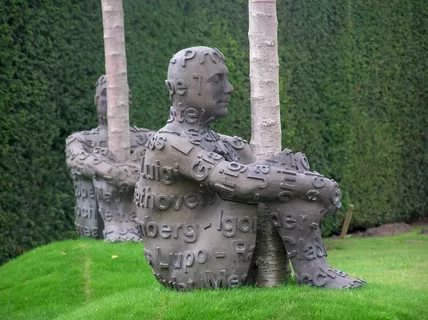

dataset_updated/training_set/sculpture/i - 155.jpeg


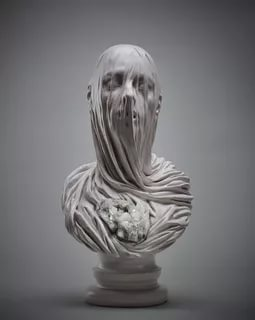

In [30]:
for index in indices.squeeze():
    image = Image.open(filename_paths[index])
    print(filename_paths[index])
    image.show()

In [44]:
X_test, y_test, _, _ = retrieve_images(test_dirs_paths)

# Encode class labels as integers
y_test_encoded = label_encoder.transform(y_test)

print(f"Shape of X: {X_test.shape}")
print(f"Shape of y: {y_test_encoded.shape}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Shape of X: (1107, 150, 150, 3)
Shape of y: (1107,)
35/35 [==============================] - 1s 14ms/step - loss: 0.4415 - accuracy: 0.8546
Test Loss: 0.4414913058280945
Test Accuracy: 0.8545618653297424


In [62]:
base_path = "dataset_updated/training_set"

file_sizes = dict() 

for dir_ in os.listdir(base_path):
    file_sizes[dir_] = len(os.listdir(os.path.join(base_path, dir_)))

In [63]:
file_sizes

{'drawings': 1126,
 'engraving': 785,
 'iconography': 2134,
 'painting': 2358,
 'sculpture': 1893}

In [64]:
np.array(list(file_sizes.values()))  / sum(file_sizes.values())

array([0.13572806, 0.09462392, 0.2572324 , 0.28423337, 0.22818226])